In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_misc

sys.path.append('/om2/user/msaddler/tfauditoryutil')
import util_spkr_word_psychophysics_figures


In [2]:
list_fn = glob.glob('data/spkr_discrimination_timit_ssn_2023SEP08/subj_*.csv')
list_df = []

for fn in list_fn:
    if 'undefined' not in fn:
        try:
            df = pd.read_csv(fn)
        except pd.errors.ParserError as e:
            print(f"{e}\n|____ SKIPPING last row of {fn}")
            df = pd.read_csv(fn, nrows=len(open(fn).readlines()) - 2)
        list_df.append(df)


Error tokenizing data. C error: EOF inside string starting at row 923
|____ SKIPPING last row of data/spkr_discrimination_timit_ssn_2023SEP08/subj_5d470786da637a00014ba26f.csv
Error tokenizing data. C error: EOF inside string starting at row 405
|____ SKIPPING last row of data/spkr_discrimination_timit_ssn_2023SEP08/subj_6441795624090301ddeba81e.csv
Error tokenizing data. C error: EOF inside string starting at row 1384
|____ SKIPPING last row of data/spkr_discrimination_timit_ssn_2023SEP08/subj_5d45d2c3b30ae50001578172.csv
Error tokenizing data. C error: EOF inside string starting at row 923
|____ SKIPPING last row of data/spkr_discrimination_timit_ssn_2023SEP08/subj_63ecfe8661889f0486bec1dc.csv
Error tokenizing data. C error: EOF inside string starting at row 491
|____ SKIPPING last row of data/spkr_discrimination_timit_ssn_2023SEP08/subj_5d74001d391b6600175f433b.csv
Error tokenizing data. C error: EOF inside string starting at row 923
|____ SKIPPING last row of data/spkr_discriminati

In [3]:
df_trials = pd.read_pickle('stim/timit_ssn/config.pkl')
df_trials['condition'] = df_trials['index_condition'].map(lambda _: 'condition{:02d}'.format(_))
map_to_snr = dict(zip(df_trials['condition'], df_trials['snr']))
map_to_background_condition = dict(zip(df_trials['condition'], df_trials['background_condition']))
map_to_catch = lambda _: 'catch' in _


44 of 69 participants meet inclusion criteria


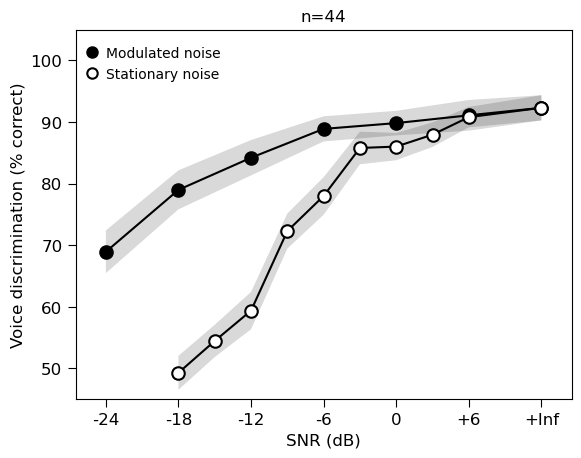

In [4]:
MIN_TRIALS_PER_CONDITION = 15
MIN_CATCH_TRIAL_MEAN = 0.95

df = pd.concat(list_df)
df = df[(~df.correct.isna()) & (df.hc_passed == True)]
df['condition'] = df['stimulus'].map(lambda _: os.path.basename(os.path.dirname(_)))

df['snr'] = df['condition'].map(map_to_snr)
df['background_condition'] = df['condition'].map(map_to_background_condition)
df['catch'] = df['condition'].map(map_to_catch)
df['snr'] = df['snr'].fillna(np.inf)
df['background_condition'] = df['background_condition'].fillna(-1)
df['n_trials_completed'] = df['trial_num'].isna()

df = df.groupby(['catch', 'background_condition', 'snr', 'output_filename']).agg({
    'correct': 'mean',
    'n_trials_completed': 'count',
}).reset_index()

df_min_trials = df.groupby('output_filename').agg({'n_trials_completed': min}).reset_index()
map_to_min_trials = dict(zip(df_min_trials['output_filename'], df_min_trials['n_trials_completed']))

n_before = len(np.unique(df.output_filename.values))
list_output_filename = np.unique(df[np.logical_and.reduce([
    df['catch'] == True,
    df['output_filename'].map(map_to_min_trials) >= MIN_TRIALS_PER_CONDITION,
    df['correct'] >= MIN_CATCH_TRIAL_MEAN,
])].output_filename.values)
print(f'{len(list_output_filename)} of {n_before} participants meet inclusion criteria')

df = df[df['output_filename'].isin(list_output_filename)]
df = util_misc.flatten_columns(df.groupby(['catch', 'background_condition', 'snr']).agg({
    'correct': [list, 'mean', 'sem'],
    'n_trials_completed': [list],
}).reset_index(), sep='_')

df_inf = df[(df.background_condition == 4) & (df.snr == np.inf)].copy()
df_inf.loc[:, 'background_condition'] = 3
df = pd.concat([df, df_inf])
df = df[df['catch'] == False].drop(columns=['catch'])
df = df.sort_values(by=['background_condition', 'snr']).reset_index(drop=True)

df['tag_expt'] = 'spkr_discrimination_timit_ssn'
df['tag_model'] = 'human'
df = df.sort_index(axis=1)

fig, ax = plt.subplots()
util_spkr_word_psychophysics_figures.make_plot_voice_discrimination(ax, df, restrict_snr=None)
ax.set_title(f"n={df['correct_list'].map(len)[0]}")
plt.show()

fn_human = '/om2/user/msaddler/tfauditoryutil/saved_models/HUMAN/spkr_word/human_data_saddler_2023_spkr_discrimination_timit_ssn.pkl'
df.to_pickle(fn_human)


In [5]:
df_human = pd.read_pickle(fn_human)
print(df_human['n_trials_completed_list'].map(min).min())
df_human


16


,background_condition,correct_list,correct_mean,correct_sem,n_trials_completed_list,snr,tag_expt,tag_model
0,3.0,"[0.4642857142857143, 0.3333333333333333, 0.533...",0.492953,0.013773,"[28, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",-18.0,spkr_discrimination_timit_ssn,human
1,3.0,"[0.4230769230769231, 0.6666666666666666, 0.566...",0.544678,0.013098,"[26, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",-15.0,spkr_discrimination_timit_ssn,human
2,3.0,"[0.5769230769230769, 0.6666666666666666, 0.666...",0.593866,0.015172,"[26, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",-12.0,spkr_discrimination_timit_ssn,human
3,3.0,"[0.7916666666666666, 0.7333333333333333, 0.7, ...",0.723028,0.014258,"[24, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",-9.0,spkr_discrimination_timit_ssn,human
4,3.0,"[0.8695652173913043, 0.9333333333333333, 0.7, ...",0.780016,0.015244,"[23, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",-6.0,spkr_discrimination_timit_ssn,human
5,3.0,"[0.8260869565217391, 0.9333333333333333, 1.0, ...",0.857917,0.013250,"[23, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",-3.0,spkr_discrimination_timit_ssn,human
6,3.0,"[1.0, 0.9, 0.7333333333333333, 0.8666666666666...",0.860160,0.011086,"[26, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",0.0,spkr_discrimination_timit_ssn,human
7,3.0,"[0.9583333333333334, 0.9, 0.9666666666666667, ...",0.879542,0.009968,"[24, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",3.0,spkr_discrimination_timit_ssn,human
8,3.0,"[0.88, 0.8666666666666667, 0.9666666666666667,...",0.907934,0.008292,"[25, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",6.0,spkr_discrimination_timit_ssn,human
9,3.0,"[0.9583333333333334, 0.9333333333333333, 0.9, ...",0.923123,0.010230,"[24, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3...",inf,spkr_discrimination_timit_ssn,human


In [6]:
df = pd.concat(list_df)
df = df[(~df.correct.isna()) & (df.hc_passed == True)]
df['condition'] = df['stimulus'].map(lambda _: os.path.basename(os.path.dirname(_)))

df['snr'] = df['condition'].map(map_to_snr)
df['background_condition'] = df['condition'].map(map_to_background_condition)
df['catch'] = df['condition'].map(map_to_catch)
df['snr'] = df['snr'].fillna(np.inf)
df['background_condition'] = df['background_condition'].fillna(-1)

df['include'] = df['output_filename'].isin(list_output_filename)
df = df.reset_index(drop=True).sort_index(axis=1)

fn_raw = '/om2/user/msaddler/tfauditoryutil/saved_models/HUMAN/spkr_word/human_data_saddler_2023_spkr_discrimination_timit_ssn_raw.pkl'
df.to_pickle(fn_raw)
df


,background_condition,catch,catch_trial,condition,correct,correct_response,failed_audio,failed_images,failed_video,hc_answer,...,snr,stim_type,stimulus,success,time_elapsed,timeout,trial_index,trial_num,trial_type,view_history
0,4.0,False,0.0,condition14,1.0,0.0,NaN,NaN,NaN,NaN,...,6.0,NaN,stim/timit_ssn/condition14/479.wav,NaN,277378.0,NaN,18.0,0.0,html-button-response,NaN
1,4.0,False,0.0,condition10,1.0,0.0,NaN,NaN,NaN,NaN,...,-18.0,NaN,stim/timit_ssn/condition10/451.wav,NaN,284402.0,NaN,21.0,1.0,html-button-response,NaN
2,4.0,False,0.0,condition10,1.0,0.0,NaN,NaN,NaN,NaN,...,-18.0,NaN,stim/timit_ssn/condition10/487.wav,NaN,291437.0,NaN,24.0,2.0,html-button-response,NaN
3,4.0,False,0.0,condition09,1.0,0.0,NaN,NaN,NaN,NaN,...,-24.0,NaN,stim/timit_ssn/condition09/361.wav,NaN,298852.0,NaN,27.0,3.0,html-button-response,NaN
4,3.0,False,0.0,condition03,1.0,0.0,NaN,NaN,NaN,NaN,...,-9.0,NaN,stim/timit_ssn/condition03/261.wav,NaN,306589.0,NaN,30.0,4.0,html-button-response,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28024,3.0,False,0.0,condition04,1.0,1.0,NaN,NaN,NaN,NaN,...,-6.0,NaN,stim/timit_ssn/condition04/033.wav,NaN,4534448.0,NaN,326.0,103.0,html-button-response,NaN
28025,3.0,False,0.0,condition04,1.0,1.0,NaN,NaN,NaN,NaN,...,-6.0,NaN,stim/timit_ssn/condition04/121.wav,NaN,4539956.0,NaN,329.0,104.0,html-button-response,NaN
28026,3.0,False,0.0,condition06,0.0,1.0,NaN,NaN,NaN,NaN,...,0.0,NaN,stim/timit_ssn/condition06/233.wav,NaN,4545903.0,NaN,332.0,105.0,html-button-response,NaN
28027,3.0,False,0.0,condition05,0.0,0.0,NaN,NaN,NaN,NaN,...,-3.0,NaN,stim/timit_ssn/condition05/266.wav,NaN,4552313.0,NaN,335.0,106.0,html-button-response,NaN
